In [10]:
import numpy as np
import matplotlib.pyplot as plt

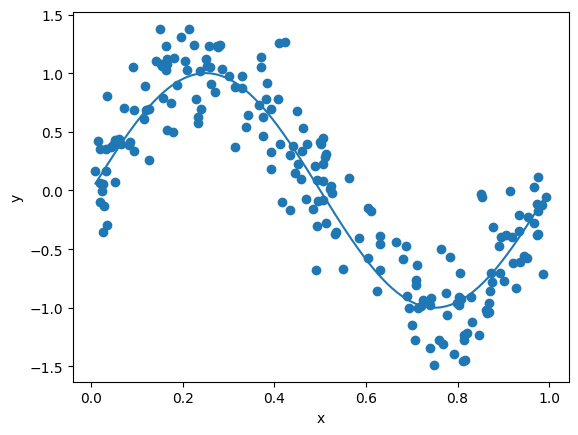

In [170]:
# set up sinusoidal data with Gaussian noise
n = 200
sig_noise = 0.3

# uniform sampling of x
#x = np.linspace(0., 1., n)

# random sampling of x
xrng = np.random.default_rng(seed=775)
x = xrng.random(n)

# add noise to y
dyrng = np.random.default_rng(seed=48)
dy = dyrng.normal(loc=0,scale=sig_noise,size=n)
y = np.sin(2*np.pi*x) + dy

# sort data by x values
ind = np.argsort(x)
xsort = x[ind]
ysort = y[ind]
data = np.vstack([xsort,ysort]).T

# also plot underlying sin function
xtrue = np.linspace(x.min(), x.max(), 200)
ytrue = np.sin(2*np.pi*xtrue)

# make plots
plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

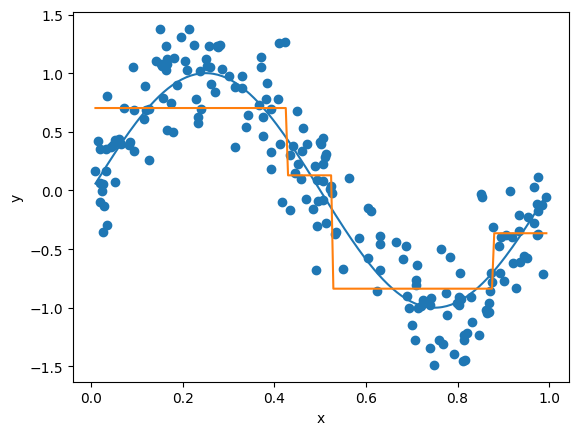

In [171]:
# build decision tree with max depth
maxDepth = 2
# minimum number of samples in a leaf
minSamples = 10

# CART cost function for regression
def cart(yLeft,yRight):
    return (np.size(yLeft)*np.var(yLeft)/(np.size(yLeft)+np.size(yRight))) + (np.size(yRight)*np.var(yRight)/(np.size(yLeft)+np.size(yRight)))

# find optimal node splitting
def split(nodeData, minSampLeaf = 1):
    nData = np.shape(nodeData)[0]   
    minCost = cart(nodeData[0:minSampLeaf,1],nodeData[minSampLeaf:nData,1])
    
    minIndex = minSampLeaf
    for i in range(minSampLeaf+1,nData-minSampLeaf+1):
        cost = cart(nodeData[0:i,1],nodeData[i:nData,1])
        
        if cost < minCost:
            minCost = cost
            minIndex = i

    return nodeData[0:minIndex], nodeData[minIndex:nData]

# initialize tree stumps
dataTree = [[data]]
valueTree = [[np.mean(y)]]
left, right = split(data, minSampLeaf=minSamples)
dataTree.append([left,right])
threshTree = [[left[-1,0] + ((right[0,0]-left[-1,0])/2.)]]
valueTree.append([np.mean(left[:,1]), np.mean(right[:,1])])

# grow the tree deeper
for i in range(2, maxDepth+1):
    dataTree.append([])
    threshTree.append([])
    valueTree.append([])
    
    for j in range(2**(i-1)):         
        left, right = split(dataTree[i-1][j], minSampLeaf=minSamples)

        # only split if new nodes have enough samples 
        if np.shape(left)[0] >= minSamples and np.shape(right)[0] >= minSamples:
            dataTree[i].append(left)
            dataTree[i].append(right)
            threshTree[i-1].append(left[-1,0] + ((right[0,0]-left[-1,0])/2.))
            valueTree[i].append(np.mean(left[:,1]))
            valueTree[i].append(np.mean(right[:,1]))

        # or else copy properties from parent node
        else:
            dataTree[i].append(dataTree[i-1][j])
            dataTree[i].append(dataTree[i-1][j])
            threshTree[i-1].append(1.1)
            valueTree[i].append(valueTree[i-1][j])
            valueTree[i].append(valueTree[i-1][j])

# need funtion to traverse the decision tree for predictions
def yhat(x, thresh = [], value = [], depth = 0):
    jnext = 0
    for i in range(depth):
        if (x <= thresh[i][jnext]):
            jnext = 2*jnext
        else:
            jnext = (2*jnext) + 1

    return value[depth][jnext]

# plot decision tree prediction
xtree = np.linspace(x.min(), x.max(), 200)
ytree = np.zeros_like(xtree)
for i in range(np.size(xtree)):
    ytree[i] = yhat(xtree[i],threshTree,valueTree,maxDepth)

# make plots
plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.plot(xtree,ytree)
plt.xlabel("x")
plt.ylabel("y")
plt.show()


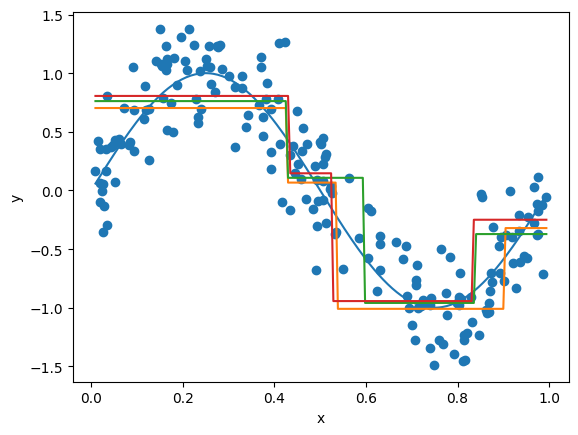

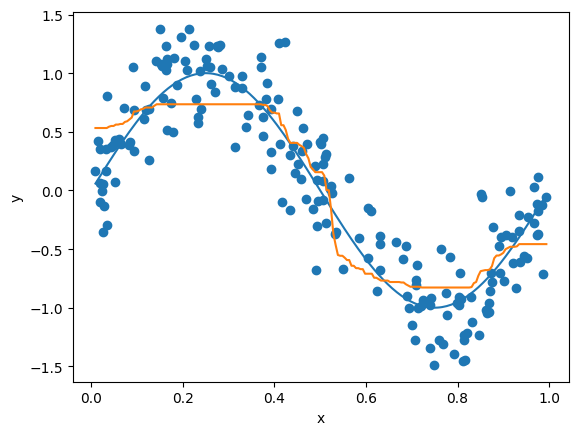

In [172]:
# now want to bag ensemble of trees
nTrees = 100
# training sample size for each tree
nSample = 100

# save tree thresholds and values
threshCol = []
valueCol = []
for iTree in range(nTrees):
    # sample data set and sort subsample
    dataRandrng = np.random.default_rng()
    dataRand = dataRandrng.choice(data, nSample)
    xrand = dataRand[:,0]
    yrand = dataRand[:,1]
    ind = np.argsort(xrand)
    xsort = xrand[ind]
    ysort = yrand[ind]
    dataSamp = np.vstack([xsort,ysort]).T   

    # initialize tree stumps
    dataTree = [[dataSamp]]
    valueTree = [[np.mean(dataSamp[:,1])]]
    left, right = split(dataSamp, minSampLeaf=minSamples)
    dataTree.append([left,right])
    threshTree = [[left[-1,0] + ((right[0,0]-left[-1,0])/2.)]]
    valueTree.append([np.mean(left[:,1]), np.mean(right[:,1])])

    # grow the tree deeper
    for i in range(2, maxDepth+1):
        dataTree.append([])
        threshTree.append([])
        valueTree.append([])
    
        for j in range(2**(i-1)):         
            left, right = split(dataTree[i-1][j], minSampLeaf=minSamples)

            # only split if new nodes have enough samples 
            if np.shape(left)[0] >= minSamples and np.shape(right)[0] >= minSamples:
                dataTree[i].append(left)
                dataTree[i].append(right)
                threshTree[i-1].append(left[-1,0] + ((right[0,0]-left[-1,0])/2.))
                valueTree[i].append(np.mean(left[:,1]))
                valueTree[i].append(np.mean(right[:,1]))

            # or else copy properties from parent node
            else:
                dataTree[i].append(dataTree[i-1][j])
                dataTree[i].append(dataTree[i-1][j])
                threshTree[i-1].append(1.1)
                valueTree[i].append(valueTree[i-1][j])
                valueTree[i].append(valueTree[i-1][j])

    threshCol.append(threshTree)
    valueCol.append(valueTree)

# output average of bagged trees
def yhatBag(x, thresh = [], value = [], depth = 0):
    sum = 0
    for i in range(len(thresh)):
        sum += yhat(x, thresh[i], value[i], depth)
    return sum/len(thresh)

# plot decision tree predictions
xtree = np.linspace(x.min(), x.max(), 200)
ytree = np.zeros((nTrees,np.size(xtree)))
for i in range(nTrees):
    for j in range(np.size(xtree)):
        ytree[i,j] = yhat(xtree[j],threshCol[i],valueCol[i],maxDepth)

# plot bagged tree predictions
xbag = xtree
ybag = np.zeros_like(xbag)
for i in range(np.size(xbag)):
    ybag[i] = yhatBag(xtree[i],threshCol,valueCol,maxDepth)

# make plots
plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.plot(xtree,ytree[0])
plt.plot(xtree,ytree[1])
plt.plot(xtree,ytree[2])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.plot(xbag,ybag)
plt.xlabel("x")
plt.ylabel("y")
plt.show()

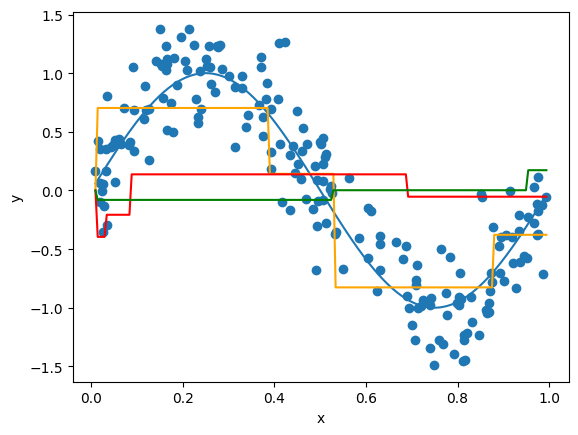

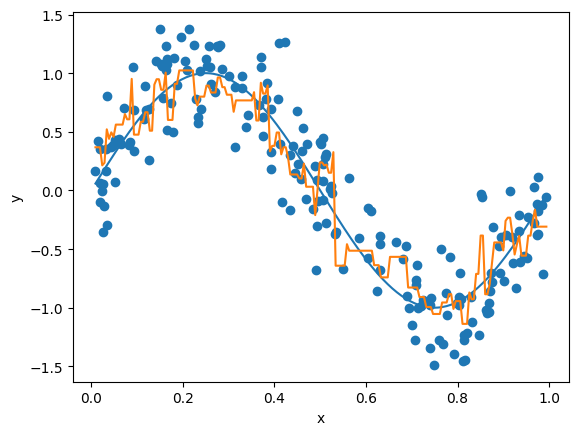

In [173]:
# now want a (gradient) boosted tree 
nTrees = 50
learnRate = 0.6
# training sample size for each tree
nSample = 200

# output of gradient boosted tree
def yhatBoost(x, thresh = [], value = [], depth = 0, rate=1):
    if len(thresh) == 0:
        return 0
    
    sum = yhat(x, thresh[0], value[0], depth)
    for i in range(1,len(thresh)):
        sum += rate*yhat(x, thresh[i], value[i], depth)
    return sum

# save tree thresholds and values
threshBoostCol = []
valueBoostCol = []
# initialize residual to training data
residual = np.copy(data)
for iTree in range(nTrees):

    # sample data set and sort subsample
    dataRandrng = np.random.default_rng()
    dataRand = dataRandrng.choice(residual, nSample)
    xrand = dataRand[:,0]
    yrand = dataRand[:,1]
    ind = np.argsort(xrand)
    xsort = xrand[ind]
    ysort = yrand[ind]
    dataSamp = np.vstack([xsort,ysort]).T   

    # initialize tree stumps
    dataTree = [[dataSamp]]
    valueTree = [[np.mean(dataSamp[:,1])]]
    left, right = split(dataSamp, minSampLeaf=minSamples)
    dataTree.append([left,right])
    threshTree = [[left[-1,0] + ((right[0,0]-left[-1,0])/2.)]]
    valueTree.append([np.mean(left[:,1]), np.mean(right[:,1])])

    # grow the tree deeper
    for i in range(2, maxDepth+1):
        dataTree.append([])
        threshTree.append([])
        valueTree.append([])
    
        for j in range(2**(i-1)):         
            left, right = split(dataTree[i-1][j], minSampLeaf=minSamples)

            # only split if new nodes have enough samples 
            if np.shape(left)[0] >= minSamples and np.shape(right)[0] >= minSamples:
                dataTree[i].append(left)
                dataTree[i].append(right)
                threshTree[i-1].append(left[-1,0] + ((right[0,0]-left[-1,0])/2.))
                valueTree[i].append(np.mean(left[:,1]))
                valueTree[i].append(np.mean(right[:,1]))

            # or else copy properties from parent node
            else:
                dataTree[i].append(dataTree[i-1][j])
                dataTree[i].append(dataTree[i-1][j])
                threshTree[i-1].append(1.1)
                valueTree[i].append(valueTree[i-1][j])
                valueTree[i].append(valueTree[i-1][j])

    threshBoostCol.append(threshTree)
    valueBoostCol.append(valueTree)

    # update residual for boosting
    for j in range(n):
        residual[j] = np.array([data[j,0], data[j,1] - yhatBoost(data[j,0],threshBoostCol,valueBoostCol,maxDepth)])

# plot decision tree predictions
xtree = np.linspace(x.min(), x.max(), 200)
ytree = np.zeros((nTrees,np.size(xtree)))
for i in range(nTrees):
    for j in range(1,np.size(xtree)):
        if i == 0:
            ytree[i,j] = yhat(xtree[j],threshBoostCol[i],valueBoostCol[i],maxDepth)
        else:
            ytree[i,j] = learnRate*yhat(xtree[j],threshBoostCol[i],valueBoostCol[i],maxDepth)

# plot boosted tree predictions
xboost = xtree
yboost = np.zeros_like(xboost)
for i in range(np.size(xboost)):
    yboost[i] = yhatBoost(xtree[i],threshBoostCol,valueBoostCol,maxDepth,learnRate)

# make plots
plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.plot(xtree,ytree[0], c='orange')
plt.plot(xtree,ytree[1], c='red')
plt.plot(xtree,ytree[2], c='green')
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.scatter(x,y)
plt.plot(xtrue,ytrue)
plt.plot(xboost,yboost)
plt.xlabel("x")
plt.ylabel("y")
plt.show()